<span style = "color:blue; font-size:24px">ARIMADecisionTreeTester</span>
<span style = "color:blue; font-size:24px">MultiYear</span>
<span style = "color:blue; font-size:24px"> Reconnaissance<span>

ZeekData24 Attack Profiles

Dataset 1: Multiple Attack Types (Credential Access|236706|, Reconnaissance|12762|, Initial Access|2172|, Privilege Escalation|1251|, Persistence|1251|, Defense Evasion|1251|, Exfiltration|50|)

Dataset 2: Multiple Attack Types (Credential Access|45491|, Reconnaissance|3339|, Initial Access|576|, Privilege Escalation|336|, Persistence|336|, Defense Evasion|336|, Exfiltration|30|)

Dataset 3: Multiple Attack Types (Credential Access|150887|, Reconnaissance|10834|, Initial Access|2090|, Privilege Escalation|1193|, Persistence|1193|, Defense Evasion|1193|, Exfiltration|188|)

Dataset 4: Multiple Attack Types (Credential Access|341945|, Reconnaissance|24233|, Initial Access|4602|, Privilege Escalation|2591|, Persistence|2591|, Defense Evasion|2591|, Exfiltration|268|)

Dataset 5: Multiple Attack Types (Credential Access|96159|, Reconnaissance|6927|, Initial Access|1222|, Privilege Escalation|677|, Persistence|677|, Defense Evasion|677|, Exfiltration|23|)

Datest 6: Benign Data

Dataset 7: Benign Data

Zeekdata22 Attack Profiles

Dataset 1: Benign

Dataset 2: Attacks (Reconnaissance|9278720|, Discovery|2086|)

Dataset 3: Attacks (Credential Access|31|, Privilege Escalation|13|, Exfiltration|7|, Lateral Movement|4|, Resource Development|3|, Reconnaissance|2|, Persistence|1|, Initial Access|1|, Defense Evasion|1|)

This revision tests the Decision Tree Model on different combinations of 2022 and 2024 data but focuses on Credential Access.

NOTE: This revision is adapted to implement an upgrade python 3.12 version which does not allow for the use of pdmarima, so the arima_functions script must use statsmodels to work properly. Previous versions may be considered obsolete when using this new version of python.

<span style = "color:blue; font-size:24px">Preprocessing for ARIMA Model</span>

In [1]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

UID = "raf46"                   # Your Argonet ID.
hadoop_master = "192.168.1.250"  # IP address to Spark Master, which, for our cluster, is the same as the Hadoop Name node address.  
# Create spark session with variables below.  Please try to remember to add your argonet ID to the appName, so that we know who a running job belongs to.
spark = SparkSession.builder.appName("Pyspark Example Script - " + UID)                        \
                            .master("spark://" + hadoop_master + ":7077")                      \
                            .config("SPARK_LOCAL_IP", hadoop_master)                           \
                            .config("spark.driver.cores", "2")                                 \
                            .config("spark.driver.memory", "128g")                              \
                            .config("spark.executor.memory", "128g")                            \
                            .config("spark.executor.cores", "4")                               \
                            .config("spark.dynamicAllocation.shuffleTracking.enabled", "true") \
                            .config("spark.dynamicAllocation.enabled", "true")                 \
                            .config("spark.dynamicAllocation.minExecutors", "2")               \
                            .config("spark.dynamicAllocation.maxExecutors", "8")               \
                            .config("spark.executor.instances", "4")                           \
                            .getOrCreate()

def load_data(data_paths):
    df_list = []
    for i, path in enumerate(data_paths):
        print(f"Loading data from path {i+1}/{len(data_paths)}: {path}")
        df = spark.read.parquet(path)
        df_list.append(df)
        print(f"Count of rows in dataset:  {df.count()}")
    print("Data loading complete.")
    return df_list

def process_data_ARIMA(df_list):
    processed_df_list = []
    mitre_labels = [
        "Privilege Escalation", "Execution", "Persistence", "Defense Evasion",
        "Credential Access", "Discovery", "Lateral Movement", "Collection",
        "Exfiltration", "Command and Control", "Impact", "Reconnaissance", "Resource Development"
    ]

    for i, df in enumerate(df_list):
        print(f"Processing DataFrame {i+1}/{len(df_list)}")
        df = df.withColumn("label_tactic_binary", F.when(F.col("label_tactic") == "none", 0).otherwise(1))
        df = df.withColumn("label_tactic_split", F.split("label_tactic", ","))
        df = df.withColumn("label_tactic_binary_encoded", F.expr(
            "array(" + ",".join([f"IF(array_contains(label_tactic_split, '{label}'), 1, 0)" for label in mitre_labels]) + ")"
        ))
        df = df.withColumn("ts", F.from_unixtime("ts").cast("timestamp"))
        window_size = "1 seconds"
        df_agg = df.groupBy(F.window("ts", window_size)) \
            .agg(
                F.sum("duration").alias("sum_duration"),
                F.sum("orig_bytes").alias("sum_orig_bytes"),
                F.sum("resp_bytes").alias("sum_resp_bytes"),
                F.sum("orig_ip_bytes").alias("sum_orig_ip_bytes"),
                F.sum("resp_ip_bytes").alias("sum_resp_ip_bytes"),
                F.count("*").alias("connection_count"),
                F.max("label_tactic_binary").alias("label_tactic_binary_agg"),
                F.collect_set("label_tactic_split").alias("label_tactic_split_agg"),
                F.max("label_tactic_binary_encoded").alias("label_tactic_binary_encoded_agg")
            )
        df_agg_flat = df_agg.select(
            F.col("window.start").alias("window_start"),
            F.col("window.end").alias("window_end"),
            "sum_duration",
            "sum_orig_bytes",
            "sum_resp_bytes",
            "sum_orig_ip_bytes",
            "sum_resp_ip_bytes",
            "connection_count",
            "label_tactic_binary_agg",
            "label_tactic_split_agg",
            "label_tactic_binary_encoded_agg"
        )
        df_agg_sorted = df_agg_flat.orderBy("window_start")
        df_pandas_sorted = df_agg_sorted.toPandas()
        df_pandas_sorted["sum_orig_bytes_log"] = np.log1p(df_pandas_sorted["sum_orig_bytes"])
        processed_df_list.append(df_pandas_sorted)
        print(f"DataFrame {i+1} processed successfully.")
    print("Data processing complete.")
    return processed_df_list

# Define paths
data_paths = [
   "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-10-27 - 2024-11-03/part-00000-69700ccb-c1c1-4763-beb7-cd0f1a61c268-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-11-03 - 2024-11-10/part-00000-f078acc1-ab56-40a6-a6e1-99d780645c57-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-01-16 - 2022-01-23/part-00000-cbf26680-106d-40e7-8278-60520afdbb0e-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-06 - 2022-02-13/part-00000-df678a79-4a73-452b-8e72-d624b2732f17-c000.snappy.parquet",
    "hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData22/parquet/2022-02-13 - 2022-02-20/part-00000-1da06990-329c-4e38-913a-0f0aa39b388d-c000.snappy.parquet"
    ]

# Define target Attack type
valid_tactics = ["Reconnaissance", "none"]

# Load and combine data, then shuffle
def combine_and_shuffle_data(data_paths, random_seed=42):
    # Load and combine all data
    df_list = load_data(data_paths)

    # Select relevant columns and fill na before combining
    for i in range(len(df_list)):
        df_list[i] = df_list[i].select("ts", "duration", "orig_bytes", "resp_bytes", "orig_ip_bytes", "resp_ip_bytes", "label_tactic")
        df_list[i] = df_list[i].fillna({
            "duration": 0,
            "orig_bytes": 0,
            "resp_bytes": 0,
            "orig_ip_bytes": 0,
            "resp_ip_bytes": 0,
            "label_tactic": "none"
        })
    # Combine all processed DataFrames
    combined_df = df_list[0]
    print(f"Initial DataFrame row count: {combined_df.count()}")
    for df in df_list[1:]:
        combined_df = combined_df.union(df)
        i=0

    # Shuffle the combined DataFrame
    shuffled_df = combined_df.orderBy(F.rand(seed=random_seed))
    print(f"Row count after shuffling: {shuffled_df.count()}")
    
    print("Data combined and shuffled successfully.")
    return shuffled_df

# Combine and shuffle the data
shuffled_df = combine_and_shuffle_data(data_paths)

# Create a pseudo timestamp column with one-minute increments
shuffled_df = shuffled_df.withColumn(
    "ts",
    F.unix_timestamp(F.current_timestamp()) + (F.row_number().over(Window.orderBy(F.rand())) * 60)
)

# Show the first few rows of the updated DataFrame
shuffled_df.show(truncate=False)

# Show the total count of rows
print(f"Total number of rows in the shuffled DataFrame: {shuffled_df.count()}")

# Add an index column to the DataFrame
shuffled_df_with_index = shuffled_df.withColumn("row_index", F.monotonically_increasing_id())

# Split the DataFrame into chunks of 100,000 rows
chunk_size = 100000
dataframe_chunks = []

for i in range(0, shuffled_df_with_index.count(), chunk_size):
    chunk = shuffled_df_with_index.filter(
        (F.col("row_index") >= i) & (F.col("row_index") < i + chunk_size)
    ).drop("row_index")  # Drop the index column after filtering
    dataframe_chunks.append(chunk)

# Print confirmation
print(f"Shuffled DataFrame split into {len(dataframe_chunks)} chunks of {chunk_size} rows each.")

shuffled_df = dataframe_chunks[1]  # Use the second chunk for further processing

# Split the shuffled DataFrame into a Train and Test set using a 70/30 split
train_test_split = shuffled_df.randomSplit([0.7, 0.3], seed=42)
train_df = train_test_split[0]
test_df = train_test_split[1]

# Add the train and test DataFrames to a list
train_test_list = [train_df, test_df]

# Print confirmation
print("Train and Test DataFrames added to train_test_list successfully.")

# Optional: Show the sizes of the train and test DataFrames
print(f"Training DataFrame size: {train_df.count()} rows")
print(f"Testing DataFrame size: {test_df.count()} rows")

# Preprocess data for ARIMA model
processed_df_list = process_data_ARIMA(train_test_list)

# Define training and testing datasets for ARIMA model
df_train_sample = processed_df_list[0]
df_test_sample = processed_df_list[1]
# Create original DataFrames for test set
df_test_original = df_test_sample.copy()

25/04/02 17:45:40 WARN Utils: Your hostname, car-ubuntu resolves to a loopback address: 127.0.1.1; using 192.168.1.123 instead (on interface ens33)
25/04/02 17:45:40 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/02 17:45:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/02 17:45:43 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Loading data from path 1/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-02-25 - 2024-03-03/part-00000-8b838a85-76eb-4896-a0b6-2fc425e828c2-c000.snappy.parquet


Count of rows in dataset:  255443
Loading data from path 2/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-03 - 2024-03-10/part-00000-0955ed97-8460-41bd-872a-7375a7f0207e-c000.snappy.parquet
Count of rows in dataset:  50444
Loading data from path 3/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-10 - 2024-03-17/part-00000-071774ae-97f3-4f31-9700-8bfcdf41305a-c000.snappy.parquet
Count of rows in dataset:  167578
Loading data from path 4/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-17 - 2024-03-24/part-00000-5f556208-a1fc-40a1-9cc2-a4e24c76aeb3-c000.snappy.parquet
Count of rows in dataset:  378821
Loading data from path 5/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekData24/parquet/2024-03-24 - 2024-03-31/part-00000-ea3a47a3-0973-4d6b-a3a2-8dd441ee7901-c000.snappy.parquet
Count of rows in dataset:  106362
Loading data from path 6/10: hdfs://192.168.1.250:9000/datasets-uwf-edu/UWF-ZeekDat

25/04/02 17:46:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
          

+----------+---------------------+----------+----------+-------------+-------------+-----------------+
|ts        |duration             |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic     |
+----------+---------------------+----------+----------+-------------+-------------+-----------------+
|1743634021|4.999637603759766E-4 |0         |0         |240          |0            |Reconnaissance   |
|1743634081|5.509853363037109E-4 |0         |0         |176          |160          |Reconnaissance   |
|1743634141|3.7097930908203125E-4|0         |0         |176          |0            |Reconnaissance   |
|1743634201|3.2901763916015625E-4|0         |0         |240          |0            |Reconnaissance   |
|1743634261|5.571842193603516E-4 |0         |0         |176          |160          |Reconnaissance   |
|1743634321|3.2401084899902344E-4|0         |0         |176          |0            |Reconnaissance   |
|1743634381|3.681182861328125E-4 |0         |0         |176          |0  

25/04/02 17:46:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:27 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 1

Training DataFrame size: 69941 rows


25/04/02 17:46:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:46:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 73:>                                                         (0 + 1) / 1]

Testing DataFrame size: 30059 rows
Processing DataFrame 1/2


25/04/02 17:47:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
          

DataFrame 1 processed successfully.
Processing DataFrame 2/2


25/04/02 17:47:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:47:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
          

DataFrame 2 processed successfully.
Data processing complete.


<span style = "color:blue; font-size:24px">Preprocessing for Decision Tree</span>

In [2]:
# Spark imports
import pyspark
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, LongType, StringType
from pyspark.sql.window import Window

# Python imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix
import seaborn as sns
import openpyxl
from openpyxl import Workbook
import os

# Function to load and preprocess data
def preprocess_data_decision_tree(df):
   #Select and cast relevant columns
    df = df.select(
        F.col("ts").cast(DoubleType()),
        F.col("duration").cast(DoubleType()),
        F.col("orig_bytes").cast(LongType()),
        F.col("resp_bytes").cast(LongType()),
        F.col("orig_ip_bytes").cast(LongType()),
        F.col("resp_ip_bytes").cast(LongType()),
        F.col("label_tactic").cast(StringType())
    )
    # Fill missing values
    df = df.fillna({
        "duration": 0,
        "orig_bytes": 0,
        "resp_bytes": 0,
        "orig_ip_bytes": 0,
        "resp_ip_bytes": 0
    })
    return df
    
# Preprocess the train and test sampels
decision_train_sample = preprocess_data_decision_tree(train_test_list[0])
decision_test_sample = preprocess_data_decision_tree(train_test_list[1])

# Print the schema of the DataFrame
print("Schema of decision_train_sample:")
decision_train_sample.printSchema()

print("Schema of decision_test_sample:")
decision_test_sample.printSchema()

# Show the first few rows of the DataFrame
print("\nFirst few rows of decision_train_sample:")
decision_train_sample.show(truncate=False)
print("\nFirst few rows of decision_test_sample:")
decision_test_sample.show(truncate=False)


Schema of decision_train_sample:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = false)

Schema of decision_test_sample:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = false)


First few rows of decision_train_sample:


25/04/02 17:48:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:48:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:48:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:48:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:48:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 1

+-------------+---------------------+----------+----------+-------------+-------------+--------------+
|ts           |duration             |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic  |
+-------------+---------------------+----------+----------+-------------+-------------+--------------+
|1.749634154E9|1.9073486328125E-6   |0         |78        |0            |134          |Reconnaissance|
|1.749634214E9|2.760887145996094E-4 |0         |0         |176          |0            |Reconnaissance|
|1.749634334E9|0.001062154769897461 |0         |0         |176          |160          |Reconnaissance|
|1.749634394E9|3.972053527832031E-4 |0         |0         |180          |0            |Reconnaissance|
|1.749634454E9|2.548694610595703E-4 |0         |0         |132          |0            |Reconnaissance|
|1.749634574E9|1.430511474609375E-4 |0         |0         |180          |0            |Reconnaissance|
|1.749634754E9|5.328655242919922E-4 |0         |0         |240          |

25/04/02 17:48:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:48:45 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:48:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
[Stage 105:>                                                        (0 + 1) / 1]

+-------------+---------------------+----------+----------+-------------+-------------+-----------------+
|ts           |duration             |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic     |
+-------------+---------------------+----------+----------+-------------+-------------+-----------------+
|1.749634295E9|5.005246162414551    |128       |0         |240          |0            |none             |
|1.749634535E9|3.299713134765625E-4 |0         |0         |240          |0            |Reconnaissance   |
|1.749634655E9|0.0010330677032470703|58        |58        |86           |86           |none             |
|1.749634715E9|2.0694732666015625E-4|0         |0         |132          |0            |Reconnaissance   |
|1.749634955E9|1.9073486328125E-6   |0         |78        |0            |134          |Reconnaissance   |
|1.749635015E9|0.023782014846801758 |686       |11329     |4856         |47844        |Credential Access|
|1.749635075E9|5.359649658203125E-4 |0        

Calling ARIMA Model Training function
ADF Statistic: -266.062003
p-value: 0.000000
The time series is stationary (reject H0).
Seasonality detected: True, Seasonal period: 39
Finding the best ARIMA model...


/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ubuntu/pyspark-venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA p

Best ARIMA order: (0, 0, 0) with AIC: 156874.9619698912
Forecasted values: 69941    0.458338
69942    0.458338
69943    0.458338
69944    0.458338
69945    0.458338
           ...   
99995    0.458338
99996    0.458338
99997    0.458338
99998    0.458338
99999    0.458338
Name: predicted_mean, Length: 30059, dtype: float64
Actual values: [0. 0. 0. ... 0. 0. 0.]
Mean Absolute Error (MAE): 1.3883950615724228


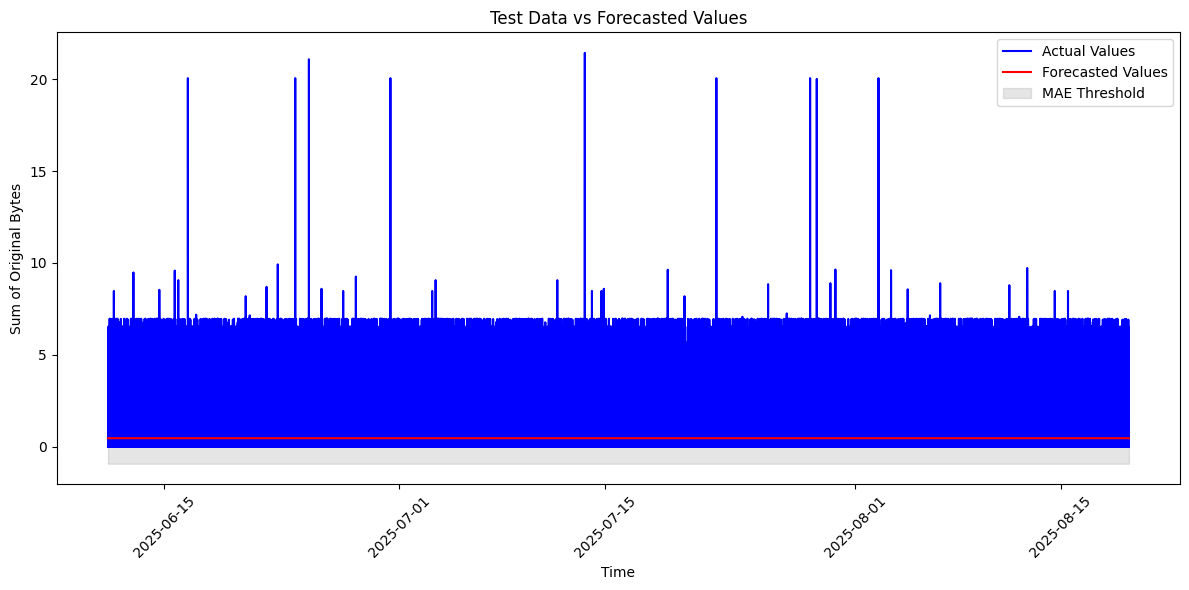

Calling Forecasted Data Processing Function
Columns in forecast_df:
Index(['Time', 'Actual', 'Forecast'], dtype='object')
Columns in df_test_original:
Index(['window_start', 'window_end', 'sum_duration', 'sum_orig_bytes',
       'sum_resp_bytes', 'sum_orig_ip_bytes', 'sum_resp_ip_bytes',
       'connection_count', 'label_tactic_binary_agg', 'label_tactic_split_agg',
       'label_tactic_binary_encoded_agg', 'sum_orig_bytes_log'],
      dtype='object')
69941   2025-06-11 04:30:28
69942   2025-06-11 04:34:28
69943   2025-06-11 04:36:28
69944   2025-06-11 04:37:28
69945   2025-06-11 04:41:28
Name: Time, dtype: datetime64[ns]

Type of decision_test_sample: <class 'pyspark.sql.dataframe.DataFrame'>
Type of filtered_result_df before conversion: <class 'pandas.core.frame.DataFrame'>

Type of filtered_result_df after conversion: <class 'pyspark.sql.dataframe.DataFrame'>


In [3]:
# Import the functions from the Python script
from arima_functions import train_arima_model, process_forecast
# Import the functions from decision_tree_functions.py
from decision_tree_functions import (
    train_and_evaluate, 
    split_data, 
    train_test_2022_2022, 
    train_test_2024_2024, 
    train_2022_test_2024, 
    train_2024_test_2022, 
    train_test_2022_2022_oversampled, 
    train_test_2024_2024_oversampled, 
    train_2022_test_2024_oversampled, 
    train_2024_test_2022_oversampled
)

import pandas as pd

# Assuming df_train_sample and df_test_sample are already defined
# Call ARIMA Model Training Function
print("Calling ARIMA Model Training function")
forecast_df = train_arima_model(df_train_sample, df_test_sample)

# Call Forecasted Data Processing Function
print("Calling Forecasted Data Processing Function")
filtered_result_df = process_forecast(df_test_original, forecast_df)

# Print the datatypes of the inputs
print("\nType of decision_test_sample:", type(decision_test_sample))
print("Type of filtered_result_df before conversion:", type(filtered_result_df))

# Convert the DataFrames to Spark DataFrames
filtered_result_df = spark.createDataFrame(filtered_result_df)
print("\nType of filtered_result_df after conversion:", type(filtered_result_df))

Decision Tree Training and Testing

Columns and types in train_df:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = false)


Entire test_df:


25/04/02 17:59:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:59:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:59:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:59:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:59:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 17:59:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 1

+-------------+---------------------+----------+----------+-------------+-------------+-----------------+
|ts           |duration             |orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic     |
+-------------+---------------------+----------+----------+-------------+-------------+-----------------+
|1.749634957E9|7.109642028808594E-4 |0         |0         |240          |160          |Reconnaissance   |
|1.749635197E9|1.3589859008789062E-4|0         |0         |180          |0            |Reconnaissance   |
|1.749635317E9|0.02497696876525879  |686       |11329     |4856         |47844        |Credential Access|
|1.749635377E9|3.139972686767578E-4 |0         |0         |180          |0            |Reconnaissance   |
|1.749635617E9|1.590251922607422E-4 |0         |0         |132          |0            |Reconnaissance   |
|1.749635677E9|2.1505355834960938E-4|0         |0         |176          |0            |Reconnaissance   |
|1.749635737E9|2.319812774658203E-4 |0        

25/04/02 18:00:00 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:09 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 1

+--------------------+-----+
|        label_tactic|count|
+--------------------+-----+
|      Reconnaissance|56525|
|                none| 7949|
|   Credential Access| 5299|
|     Defense Evasion|   30|
|Privilege Escalation|   37|
|         Persistence|   34|
|      Initial Access|   56|
|           Discovery|   10|
|        Exfiltration|    1|
+--------------------+-----+

Distinct label counts in test_df:


25/04/02 18:00:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

+--------------------+-----+
|        label_tactic|count|
+--------------------+-----+
|      Reconnaissance|24199|
|                none| 3486|
|   Credential Access| 2293|
|         Persistence|   21|
|Privilege Escalation|   13|
|      Initial Access|   31|
|           Discovery|    4|
|     Defense Evasion|   12|
+--------------------+-----+



25/04/02 18:00:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:00:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 1


Model for label_tactic: Reconnaissance
Accuracy: 0.9913170764163811
Precision: 0.9903930656055662
Recall: 0.9924149173292525
F1 Score: 0.9905032196160184

Predictions for each row in the test dataframe:


25/04/02 18:03:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:03:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:03:42 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

+--------------------------------------------------+-----+----------+
|features                                          |label|prediction|
+--------------------------------------------------+-----+----------+
|[1.1106598377227783,1008.0,16583.0,6352.0,69900.0]|0    |0.0       |
|(5,[0,3],[3.311634063720703E-4,132.0])            |1    |1.0       |
|(5,[0,3],[2.7108192443847656E-4,132.0])           |1    |1.0       |
|(5,[0,3],[2.989768981933594E-4,176.0])            |1    |1.0       |
|(5,[0,3],[2.090930938720703E-4,240.0])            |1    |1.0       |
|(5,[0,3],[2.269744873046875E-4,132.0])            |1    |1.0       |
|(5,[0,3],[3.368854522705078E-4,240.0])            |1    |1.0       |
|(5,[0,3],[1.010894775390625E-4,180.0])            |1    |1.0       |
|[0.0010929107666015625,47.0,47.0,75.0,75.0]       |0    |0.0       |
|(5,[0,3],[1.800060272216797E-4,180.0])            |1    |1.0       |
|(5,[0,3],[2.300739288330078E-4,132.0])            |1    |1.0       |
|[1.5020370483398438

25/04/02 18:03:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:03:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:03:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:04:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:04:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:04:03 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 1

Length of y_true: 30059
Length of y_pred: 30059
Number of missing values in y_true: 0
Number of missing values in y_pred: 0


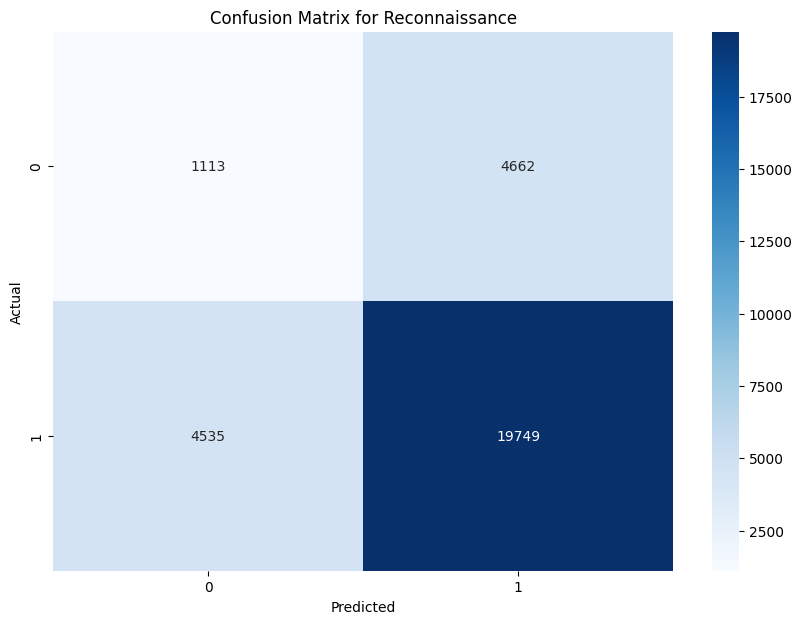

Confusion Matrix plotted.


In [4]:
#train_df, test_df, tactic, train_year, test_year, split_ratio

train_df = decision_train_sample
test_df = decision_test_sample

# Define the parameters
#tactic = "Credential Access"
tactic = "Reconnaissance"

train_year = "2024_2022"

test_year = "2024_2022"

split_ratio = "1"

# Print the columns and their types for train_df
print("Columns and types in train_df:")
train_df.printSchema()

# Print the test_df
print("\nEntire test_df:")
test_df.show(truncate=False)

#Show the distinct label counts
print("Distinct label counts in train_df:")
train_df.groupBy("label_tactic").count().show()
print("Distinct label counts in test_df:")
test_df.groupBy("label_tactic").count().show()

# Call the train_and_evaluate function
train_and_evaluate(train_df, test_df, tactic, train_year, test_year, split_ratio)

<span style = "color:blue; font-size:24px">Training with 2024 and 2022 Combined Data & Testing with ARIMA Result Dataframe</span>

Columns and types in train_df:
root
 |-- ts: double (nullable = true)
 |-- duration: double (nullable = false)
 |-- orig_bytes: long (nullable = false)
 |-- resp_bytes: long (nullable = false)
 |-- orig_ip_bytes: long (nullable = false)
 |-- resp_ip_bytes: long (nullable = false)
 |-- label_tactic: string (nullable = false)


Entire test_df:


25/04/02 18:05:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:05:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-------------------+-------------------+---------------------+-------------------+------+----------+----------+-------------+-------------+--------------+
|window_start       |window_start       |duration             |Forecast           |Actual|orig_bytes|resp_bytes|orig_ip_bytes|resp_ip_bytes|label_tactic  |
+-------------------+-------------------+---------------------+-------------------+------+----------+----------+-------------+-------------+--------------+
|2025-06-11 04:30:28|2025-06-11 04:30:28|4.057884216308594E-4 |0.45833844377479177|0.0   |0         |0         |180          |0            |Reconnaissance|
|2025-06-11 04:34:28|2025-06-11 04:34:28|4.849433898925781E-4 |0.45833844377479177|0.0   |0         |0         |240          |0            |Reconnaissance|
|2025-06-11 04:36:28|2025-06-11 04:36:28|5.271434783935547E-4 |0.45833844377479177|0.0   |0         |0         |176          |0            |Reconnaissance|
|2025-06-11 04:37:28|2025-06-11 04:37:28|31.688445806503296   |0

25/04/02 18:05:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:05:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:05:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:05:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
                                                                                

+--------------+-----+
|  label_tactic|count|
+--------------+-----+
|Reconnaissance|24314|
|          none| 3446|
+--------------+-----+

Distinct label counts in test_df:


25/04/02 18:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:05:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------+-----+
|  label_tactic|count|
+--------------+-----+
|          none|  374|
|Reconnaissance|23203|
+--------------+-----+



25/04/02 18:06:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:06:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:06:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:06:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:06:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 18:06:08 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/04/02 1


Model for label_tactic: Reconnaissance
Accuracy: 0.9974975611825084
Precision: 0.997488652701502
Recall: 0.9974975611825083
F1 Score: 0.9973997392340447

Predictions for each row in the test dataframe:
+------------------------------------------+-----+----------+
|features                                  |label|prediction|
+------------------------------------------+-----+----------+
|(5,[0,3],[4.057884216308594E-4,180.0])    |1    |1.0       |
|(5,[0,3],[4.849433898925781E-4,240.0])    |1    |1.0       |
|(5,[0,3],[5.271434783935547E-4,176.0])    |1    |1.0       |
|[31.688445806503296,0.0,0.0,240.0,1440.0] |1    |1.0       |
|(5,[0,3],[6.120204925537109E-4,240.0])    |1    |1.0       |
|(5,[0,3],[1.0018699169158936,480.0])      |1    |1.0       |
|[5.14984130859375E-4,0.0,0.0,176.0,160.0] |1    |1.0       |
|(5,[0,3],[1.6188621520996094E-4,180.0])   |1    |1.0       |
|[8.690357208251953E-4,0.0,0.0,176.0,160.0]|1    |1.0       |
|[8.349418640136719E-4,0.0,0.0,240.0,160.0]|1    |1.0

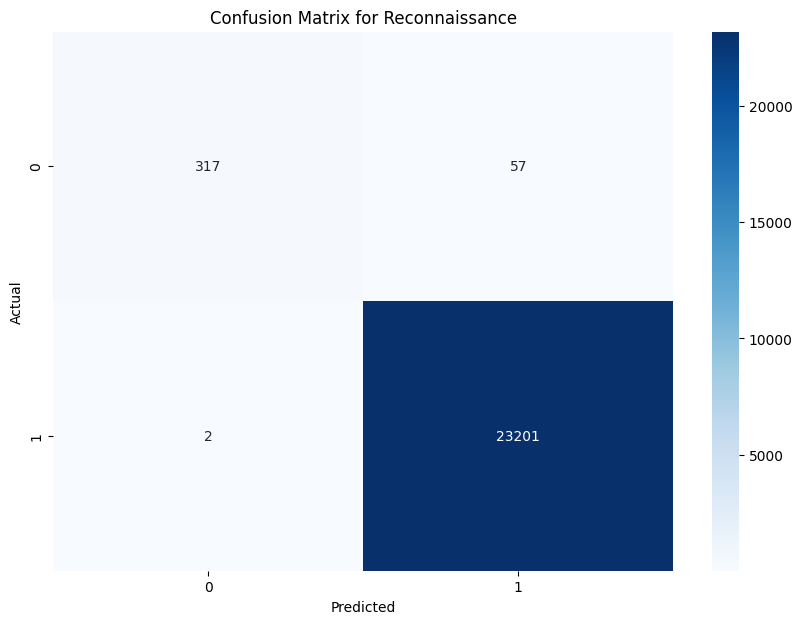

Confusion Matrix plotted.


In [5]:
#Define Test Variables for Decision Tree
#train_df, test_df, tactic, train_year, test_year, split_ratio

train_df = decision_test_sample

# Reduce train_df size to include only the first 70% of data
#train_df = train_df.limit(int(0.7 * train_df.count()))

test_df = filtered_result_df

#tactic = "Credential Access"
tactic = "Reconnaissance"

train_year = "2024"

test_year = "2022"

split_ratio = "1"

# Filter train_df to only include rows where label_tactic is either 'none' or the specified tactic
train_df = train_df.filter((F.col("label_tactic") == tactic) | (F.col("label_tactic") == "none"))

# Filter test_df to only include rows where label_tactic is either 'none' or the specified tactic
test_df = test_df.filter((F.col("label_tactic") == tactic) | (F.col("label_tactic") == "none"))

# Print the columns and their types for train_df
print("Columns and types in train_df:")
train_df.printSchema()

# Print the test_df
print("\nEntire test_df:")
test_df.show(truncate=False)

#Show the distinct label counts
print("Distinct label counts in train_df:")
train_df.groupBy("label_tactic").count().show()
print("Distinct label counts in test_df:")
test_df.groupBy("label_tactic").count().show()

# Call the train_and_evaluate function
train_and_evaluate(train_df, test_df, tactic, train_year, test_year, split_ratio)

In [ ]:
from pyspark.ml.classification import DecisionTreeClassificationModel

# Load the Decision Tree model from the directory
loaded_decision_tree_model = DecisionTreeClassificationModel.load("decision_tree_model")
print("Decision Tree model loaded successfully.")

In [ ]:
from statsmodels.tsa.arima.model import ARIMAResults

# Load the ARIMA model from the file
loaded_arima_model = ARIMAResults.load("arima_model.pkl")
print("ARIMA model loaded successfully.")